***Задание:*** Используя *явную схему крест* и *неявную схему*, решить начально-краевую задачу для *дифференциального уравнения гиперболического типа*. Аппроксимацию второго начального условия произвести с первым и со вторым порядком. Осуществить реализацию трех вариантов аппроксимации граничных условий, содержащих производные: *двухточечная аппроксимация с первым порядком, трехточечная аппроксимация со вторым порядком, двухточечная аппроксимация со вторым порядком*. В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением $u(x, t)$. Исследовать зависимость погрешности от сеточных параметров $\tau$ и $h$.

In [1]:
from ipywidgets import interact
from IPython.display import display
import matplotlib.pyplot as plt
import math
import warnings
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

***Уравнение:***

$$\displaystyle\frac{\partial^2 u}{\partial t^2} =  \displaystyle\frac{\partial^2 u}{\partial x^2} -5 u $$

\begin{equation*}
 \begin{cases}
   u_{x}' (0, \: t) = 2u(0, t)
   \\
   u_{x}' (1, \: t) =  2u(1, t)
   \\
   u(x, \: 0) = \psi_1(x) = e^{2x}
   \\
   u_{t}(x, 0) = \psi_2(x) = 0
 \end{cases}
\end{equation*}

***Аналитическое решение:***
$$u(x, t) = e^{2x} \cos{t}$$

Будем решать задачу на заданном промежутке  от $0$ до $l$ по координате $x$ и на промежутке от $0$ до заданного параметра $T$ по времени $t$.

Рассмотрим конечно-разностную схему решения краевой задачи на сетке с граничными парамерами $l$, $T$ и параметрами насыщенности сетки $N$, $K$. Тогда размер шага по каждой из координат определяется:
$$h = \displaystyle\frac{l}{N-1}, \; \tau = \displaystyle\frac{T}{K-1}$$

Считая, что значения функции $u^k_j = u(x_j, t^k)$ для всех координат $x_j = j h, \; \forall j \in \{0, ..., N\}$ на предыдущих временных известно, попробуем определить значения функции на временном слое $t^{k+1}$ путем разностной апроксимации производной:
$$\displaystyle\frac{\partial^2 u}{\partial t^2}(x_j, t^k) = \displaystyle\frac{u^{k+1}_j - 2u^k_j + u^{k-1}_j}{\tau^2}$$

И одним из методов апроксимации второй производной по $x$:
$$\displaystyle\frac{\partial^2 u}{\partial x^2}(x_j, t^k)$$

Для расчета $u_j^0$ и $u_j^1$ можно использовать следующие формулы:
$$u_j^0 = \psi_1(x_j)$$
$$u_j^1 = \psi_1(x_j) + \tau \psi_2(x_j) + \frac{\tau^2}{2}\psi_1''(x_j) + O(\tau^2)$$
$$u_j^1 = \psi_1(x_j) + \tau \psi_2(x_j) + O(\tau^1)$$

In [2]:
# analytic solve
def u(x, t):
    return math.exp(2*x)*math.cos(t)

In [3]:
# class will return grid of values
class Schema:
    def __init__(self, T = 5, order2nd = True, aprx_cls = None):
        self.psi1 = lambda x: math.exp(2*x)
        self.diffpsi = lambda x: 4 * math.exp(2*x)
        self.psi2 = lambda x: 0
        self.T = T
        
        self.l0 = 0
        self.l1 = 1
        self.tau = None
        self.h = None
        self.approx = None
        self.order = order2nd
        if aprx_cls is not None:
            self._init_approx(aprx_cls)
        self.sigma = None
        
    def _init_approx(self, a_cls):
        self.approx = a_cls()
    
    def set_approx(self, aprx_cls):
        self._init_approx(self, aprx_cls)
        
    def set_l0_l1(self, l0, l1):
        self.l0 = l0
        self.l1 = l1
        
    def set_T(self, T):
        self.T = T
        
    def _compute_h(self, N):
        self.h = (self.l1 - self.l0) / N
        
    def _compute_tau(self, K):
        self.tau = self.T / K
        
    def _compute_sigma(self):
        self.sigma = self.tau*self.tau / (self.h*self.h)
      
    @staticmethod
    def nparange(start, end, step = 1):
        now = start
        e = 0.00000000001
        while now - e <= end:
            yield now
            now += step
        
    def _compute_line(self, t, x, last_line1, last_line2):
        pass
    
    def __call__(self, N=30, K=200):
        # compute t and h
        N, K = N-1, K-1
        self._compute_tau(K)
        self._compute_h(N)
        self._compute_sigma()
        ans = []
        # compute x:
        x = list(self.nparange(self.l0, self.l1, self.h))
        
        # compute first line
        last_line = list(map(self.psi1, x))
        # add copy
        ans.append(list(last_line))
        # compute second line
        if self.order:
            last_line = list(map(
                lambda a: self.psi1(a) + self.tau*self.psi2(a) + self.tau*self.tau*self.diffpsi(a)/2, 
                x
            ))
        else:
            last_line = list(map(lambda a: self.psi1(a) + self.tau*self.psi2(a), x))
        # add copy
        ans.append(list(last_line))
        
        # create grid
        X = [x, x]
        Y = [[0.0 for _ in x]]
        Y.append([self.tau for _ in x])
        # main loop
        for t in self.nparange(self.tau + self.tau, self.T, self.tau):
            # append new line
            ans.append(self._compute_line(t, x, ans[-1], ans[-2]))
            X.append(x)
            Y.append([t for _ in x])
        return X, Y, ans

<h3><center> Явная конечно-разностная схема </center></h3>

Апроксимируем вторую производную по значениям нижнего временного слоя $t^k$, а именно:

$$\displaystyle\frac{\partial^2 u}{\partial x^2}(x_j, t^k) = \displaystyle\frac{u^k_{j-1} - 2 u^k_{j} + u^k_{j+1}}{h^2}$$

Тогда получим явную схему конечно-разностного метода во внутренних узлах сетки:

$$\displaystyle\frac{u^{k+1}_j - 2u^k_j + u_j^{k-1}}{\tau^2} = \displaystyle\frac{u^k_{j-1} - 2 u^k_{j} + u^k_{j+1}}{h^2} - 5u_j^k, \; \forall j \in \{1, ..., N-1\}, \forall k \in \{0, ..., K-1\}$$

Обозначим $\sigma = \displaystyle\frac{\tau^2}{h^2}$, тогда:

$$u^{k+1}_j = \sigma (u^k_{j+1} - 2 u^k_j + u^k_{j-1}) - 5\tau^2 u^k_j + 2u^k_j - u^{k-1}_j$$

Граничные же значения $u^{k+1}_0$ и $u^{k+1}_N$ определяются граничными условиями $u_x(0, t)$ и $u_x(l, t)$ при помощи апроксимации производной.

*Значение $\sigma$ используется для анализа устойчивости решения, а именно решение устойчиво, если $\sigma \leq 1$*.

In [4]:
class Explict_Schema(Schema):
    def _compute_sigma(self):
        self.sigma =  self.tau*self.tau / (self.h * self.h)
        if self.sigma > 1:
            warnings.warn("Sigma > 1")
        
    def _compute_line(self, t, x, last_line1, last_line2):
        line = [None for _ in last_line1]
        for i in range(1, len(x) - 1):
            line[i] = self.sigma*(last_line1[i-1] - 2*last_line1[i] + last_line1[i+1])
            line[i] -= 5*self.tau*self.tau*last_line1[i]
            line[i] += 2*last_line1[i]
            line[i] -= last_line2[i]
        line[0] = self.approx.explict_0(self.h, self.sigma, line, last_line1, last_line2, self.tau)
        line[-1] = self.approx.explict_l(self.h, self.sigma, line, last_line1, last_line2, self.tau)
        return line

<h3><center>Неявная конечно-разностная схема</center></h3>

Апроксимируем вторую производную по значениям верхнего временного слоя $t^{k+1}$, а именно:

$$\displaystyle\frac{\partial^2 u}{\partial x^2}(x_j, t^k) = \displaystyle\frac{u^{k+1}_{j-1} - 2 u^{k+1}_{j} + u^{k+1}_{j+1}}{h^2}$$

Тогда получим явную схему конечно-разностного метода во внутренних узлах сетки:

$$\displaystyle\frac{u^{k+1}_j - 2u^k_j + u^{k-1}_j}{\tau^2} =  \displaystyle\frac{u^{k+1}_{j-1} - 2 u^{k+1}_{j} + u^{k+1}_{j+1}}{h^2} - 5u^{k+1}_j, \; \forall j \in \{1, ..., N-1\}, \forall k \in \{0, ..., K-1\}$$

Обозначим $\sigma = \displaystyle\frac{\tau^2}{h^2}$. Тогда значения функции на слое можно найти эффективны образом с помощью методом прогонки, где **СЛАУ**, кроме крайних двух уравнений, определяется коэффицетнами $a_j = 1$, $b_j = -(2 + 5h^2 + \displaystyle\frac{1}{\sigma})$, $c_j = 1$, $d_j = \displaystyle\frac{-2u^k_j + u^{k-1}_j}{\sigma}$ уравнений:

$$a_j u^{k+1}_{j - 1} + b_j u^{k+1}_j + c_j u^{k+1}_{j+1} = d_j, \; \forall j \in \{1, ..., N-1\}$$

Первое и последнее уравнение системы содержащие $u^{k+1}_0$ и $u^{k+1}_N$ определяются граничными условиями при помощи апроксимации производной.

*Неявная схема является абсолютно устойчивой*.

In [5]:
class Implict_Schema(Schema):
    # method from old labs
    @staticmethod
    def race_method(A, b):
        P = [-item[2] for item in A]
        Q = [item for item in b]
    
        P[0] /= A[0][1]
        Q[0] /= A[0][1]
    
        for i in range(1, len(b)):
            z = (A[i][1] + A[i][0] * P[i-1])
            P[i] /= z
            Q[i] -= A[i][0] * Q[i-1]
            Q[i] /= z
    
        x = [item for item in Q]

        for i in range(len(x) - 2, -1, -1):
            x[i] += P[i] * x[i + 1]

        return x
    
    # compute line using race method
    def _compute_line(self, t, x, last_line1, last_line2):
        A = [(1, -(2 + 5*self.h*self.h + 1/self.sigma), 1) for _ in range(1, len(x)-1)]
        w = [(last_line2[i] - 2*last_line1[i]) / self.sigma for i in range(1, len(x)-1)]
        
        # compute coeffst for first and last equation
        koeffs = self.approx.implict_0(self.h, self.sigma, last_line1, last_line2)
        A.insert(0, koeffs[:-1])
        w.insert(0, koeffs[-1])
        
        koeffs = self.approx.implict_l(self.h, self.sigma, last_line1, last_line2)
        A.append(koeffs[:-1])
        w.append(koeffs[-1])
        
        return self.race_method(A, w)

<h2><center> Апроксимация первых производных </center></h2>

In [6]:
class Approx:
    def __init__(self):
        pass 
    def explict_0(self, h, sigma, line, last_line1, last_line2, tau):
        pass
    def explict_l(self, h, sigma, line, last_line1, last_line2, tau):
        pass
    def implict_0(self, h, sigma, l0, l1):
        pass
    def implict_l(self, h, sigma, l0, l1):
        pass

<h3><center> Двухточечная первого порядка </h2></center>

Двухточечная апроксимация первого порядка в точке $x = 0$ и $x = l$ равны соответственно:
$$\displaystyle\frac{u^{k+1}_1 - u^{k+1}_0}{h} = 2u^{k+1}_0$$
$$\displaystyle\frac{u^{k+1}_N - u^{k+1}_{N-1}}{h} = 2u^{k+1}_N$$

Тогда, поскольку мы знаем значения для внутренних узлов, получаем выражения для граничных значений при явном методе:
$$u^{k+1}_0 = \displaystyle\frac{u^{k+1}_1}{(1 + 2h)}$$
$$u^{k+1}_N = \displaystyle\frac{u^{k+1}_{N-1}}{(1 - 2h)}$$

И крайние уравенения для методда прогонки в неявном методе:
$$u^{k+1}_0 (1 + 2h) - u^{k+1}_1 = 0$$
$$-u^{k+1}_{N-1} + (1 - 2h)u^{k+1}_N = 0$$

In [7]:
class approx_two_one(Approx):
    def explict_0(self, h, sigma, line, last_line1, last_line2, tau):
        return line[1] / (1 + 2*h)
    def explict_l(self, h, sigma, line, last_line1, last_line2, tau):
        return line[-2] / (1 - 2*h)
    def implict_0(self, h, sigma, l0, l1):
        return 0, (1 + 2*h), -1, 0
    def implict_l(self, h, sigma, l0, l1):
        return -1, (1 - 2*h), 0, 0

<h3><center>Трёхточечная второго порядка</center></h3>

Трёхточечна апроксимация второго порядка в точке $x = 0$ и $x = l$ равны соответственно:
$$\displaystyle\frac{-3u^{k+1}_0 + 4u^{k+1}_1 - u^{k+1}_2}{2h} = 2u^{k+1}_0$$

$$\displaystyle\frac{3u^{k+1}_N - 4u^{k+1}_{N-1} + u^{k+1}_{N-2}}{2h} = 2u^{k+1}_N$$

Тогда, поскольку мы знаем значения для внутренних узлов, получаем выражения для граничных значений при явном методе:
$$u^{k+1}_0 = \displaystyle\frac{4u^{k+1}_1 - u^{k+1}_2}{3 + 4h}$$

$$u^{k+1}_N = \displaystyle\frac{4u^{k+1}_{N-1} - u^{k+1}_{N-2}}{3 - 4h}$$

Крайние уравенения для методда прогонки в неявном методе:
$$-(2 + 4h)u^{k+1}_0 - (5h^2 -2 + \frac{1}{\sigma})u^{k+1}_1 = \frac{(-2u^k_1 + u^{k-1}_1)}{\sigma}$$

$$ -(5h^2 -2 + \frac{1}{\sigma})u^{k+1}_{N-1} - (2 - 4h)u^{k+1}_N - = \frac{(-2u^k_{N-1} + u^{k-1}_{N-1})}{\sigma}$$


In [8]:
class approx_three_two(Approx):
    def explict_0(self, h, sigma, line, last_line1, last_line2, tau):
        return (4*line[1] - line[2]) / (3 + 4*h)           
    def explict_l(self, h, sigma, line, last_line1, last_line2, tau):
        return (4*line[-2] - line[-3]) / (3 - 4*h)
    def implict_0(self, h, sigma, l0, l1):
        return 0, -(2 + 4*h), -(5*h*h + 1/sigma - 2), (-2*l0[1] + l1[1])/sigma
    def implict_l(self, h, sigma, l0, l1):
        return -(5*h*h + 1/sigma - 2), -(2 - 4*h), 0, (-2*l0[-2] + l1[-2])/sigma

<h3><center> Двухточечная второго порядка </center></h3>

Двухточечная апроксимация второго порядка в точке $x = 0$ и $x = l$ равны соответственно:
$$\displaystyle\frac{u^{k+1}_1 - u^{k+1}_{-1}}{2h} = 2 u^{k+1}_0$$

$$\displaystyle\frac{u^{k+1}_{N+1} - u^{k+1}_{N-1}}{2h} = 2 u^{k+1}_N$$

Тогда, используя апроксимацию на предыдущем временном слое, а именно при $t = t^k$, и выразив значения, выходящие за пределы сетки с помощью уравнения:
$\displaystyle\frac{u^{k-1}_j - 2 u^k_j + u^{k+1}_j}{\tau^2} = \displaystyle\frac{u^k_{j-1} - 2 u^k_{j} + u^k_{j+1}}{h^2} - 5u_j$ для значений $j=0$ и $j = N$
мы получим формулу граничных значений для явной схемы:

$$u^{k+1}_0 = \sigma(2u^k_1 - (2 + 4h)u^k_0) + (2 - 5\tau^2) u^k_0 - u^{k-1}_0 $$

$$u^{k+1}_0 = \sigma(2u^k_{N-1} + (4h - 2)u^k_N) + (2 - 5\tau^2) u^k_N - u^{k-1}_N $$

Используя аппроксимацию на слое $t^{k+1}$ получим крайние уравенения для методда прогонки в неявном методе:
$$-(2 + 5h^2 + 4h + \frac{1}{\sigma})u^{k+1}_0 + 2u^{k+1}_1 = \frac{(-2u^k_0 + u^{k-1}_0)}{\sigma}$$

$$ 2u^{k+1}_{N-1} - (2 + 5h^2 - 4h + \frac{1}{\sigma})u^{k+1}_N = \frac{(-2u^k_N + u^{k-1}_N)}{\sigma}$$


In [9]:
class approx_two_two(Approx):
    def explict_0(self, h, sigma, line, last_line1, last_line2, tau):
        ans = sigma*(2*last_line1[1] - (2 + 4*h)*last_line1[0]) 
        ans += (2 - 5*tau*tau)*last_line1[0] - last_line2[0]
        return ans
                
    def explict_l(self, h, sigma, line, last_line1, last_line2, tau):
        ans = sigma*(2*last_line1[-2] + (4*h - 2)*last_line1[-1]) 
        ans += (2 - 5*tau*tau)*last_line1[-1] - last_line2[-1]
        return ans
    
    def implict_0(self, h, sigma, l0, l1):
        return 0, -(2 + 5*h*h + 4*h + 1/sigma), 2, (-2*l0[0] + l1[0])/sigma
    
    def implict_l(self, h, sigma, l0, l1):
        return 2, -(2 + 5*h*h - 4*h + 1/sigma), 0, (-2*l0[-1] + l1[-1])/sigma

#### Вычисление погрешностей

Вычисление погрешности: $e = \| \hat{z} - z \|_2$, где $\hat{z}$,  $z$ - матрицы  вычесленных и реальных значений функции в сетке соответственно.

In [10]:
def epsilon(x, y, z, f):
    ans = 0.0
    for i in range(len(z)):
        for j in range(len(z[i])):
            temp = abs(z[i][j] - f(x[i][j], y[i][j]))
            ans = temp if temp > ans else ans
    return ans

Постоение зависимости погрешности от шага $h$.

In [11]:
def get_graphic_h(solver, real_f):
    h,e = [],[]
    for N in range(4, 50, 1):
        x, y, z = solver(N)
        h.append(solver.h)
        e.append(epsilon(x, y, z, real_f))
    return h, e

#### Явная схема

In [12]:
explict = Explict_Schema(T = 1, aprx_cls=approx_two_two)

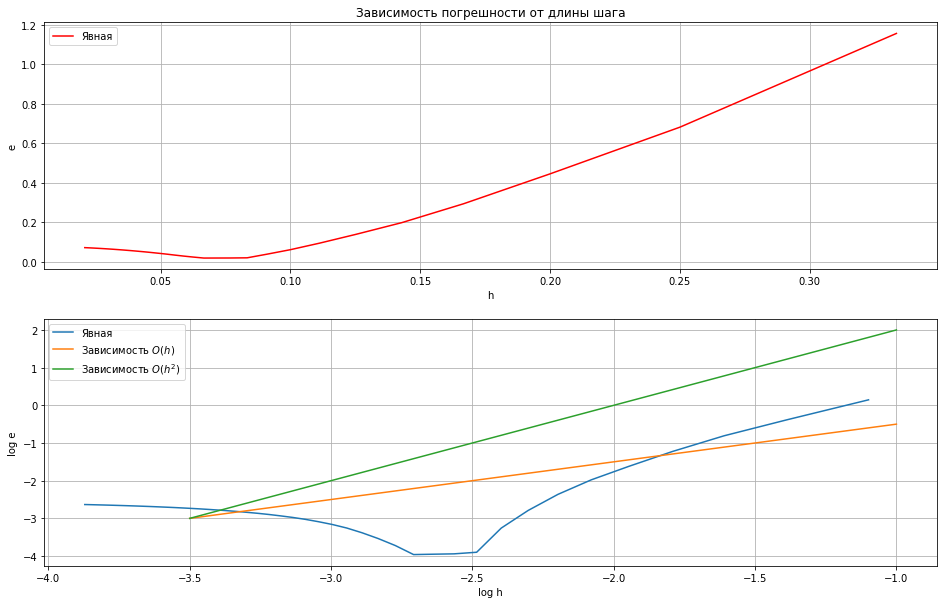

In [13]:
plt.figure(figsize = (16, 10))

plt.subplot(2, 1, 1)
plt.title("Зависимость погрешности от длины шага")
h, e = get_graphic_h(explict, u)

plt.plot(h, e, label="Явная", color = "red")
plt.xlabel("h")
plt.ylabel("e")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(list(map(math.log, h)), list(map(math.log, e)), label="Явная")
plt.plot([-3.5, -1], [-3, -0.5], label="Зависимость $O(h)$")
plt.plot([-3.5, -1], [-3, 2], label="Зависимость $O(h^2)$")
plt.xlabel("log h")
plt.ylabel("log e")
plt.legend()
plt.grid()

#### Неявная схема

In [14]:
# Krank Nikolson with O = 1 is implict schema
implict = Implict_Schema(T = 1, aprx_cls=approx_two_two)

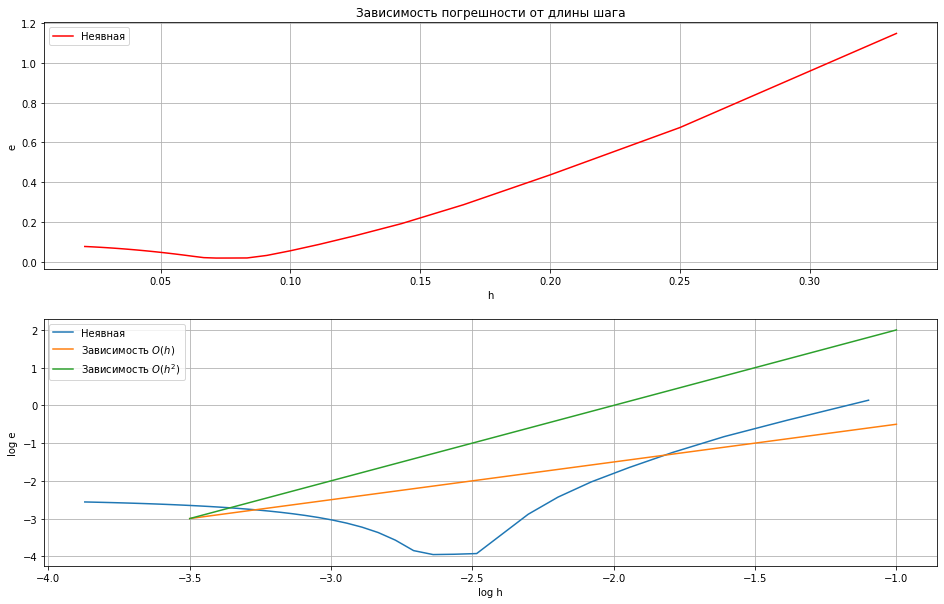

In [15]:
plt.figure(figsize = (16, 10))

plt.subplot(2, 1, 1)
plt.title("Зависимость погрешности от длины шага")
h, e = get_graphic_h(implict, u)

plt.plot(h, e, label="Неявная", color = "red")
plt.xlabel("h")
plt.ylabel("e")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(list(map(math.log, h)), list(map(math.log, e)), label="Неявная")
plt.plot([-3.5, -1], [-3, -0.5], label="Зависимость $O(h)$")
plt.plot([-3.5, -1], [-3, 2], label="Зависимость $O(h^2)$")
plt.xlabel("log h")
plt.ylabel("log e")
plt.legend()
plt.grid()

#### Вычисление погрешности

Построение зависимости погрешности от параметра $\tau$.

In [16]:
def get_graphic_tau(solver, real_f):
    tau = []
    e = []
    for K in range(3, 90):
        x, y, z = solver(K = K)
        tau.append(solver.tau)
        e.append(epsilon(x, y, z, real_f))
    return tau, e

#### Явная схема

In [17]:
explict = Explict_Schema(T = 1, aprx_cls=approx_two_two)

c:\python372\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Sigma > 1
  """


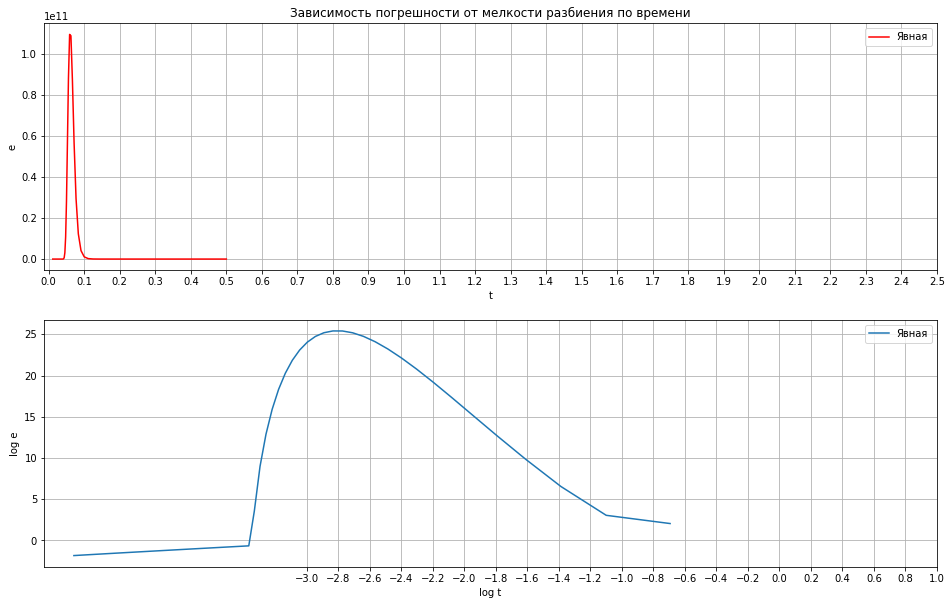

In [18]:
plt.figure(figsize = (16, 10))

plt.subplot(2, 1, 1)
plt.title("Зависимость погрешности от мелкости разбиения по времени")
tau, e = get_graphic_tau(explict, u)

plt.plot(tau, e, label="Явная", color = "red")
plt.xlabel("t")
plt.ylabel("e")
plt.xticks(list(explict.nparange(0, 2.5, 0.1)))
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(list(map(math.log, tau)), list(map(math.log, e)), label="Явная")
plt.xlabel("log t")
plt.ylabel("log e")
plt.xticks(list(explict.nparange(-3, 1, 0.2)))
plt.legend()
plt.grid()

#### Неявная схема

In [19]:
implict = Implict_Schema(T = 1, aprx_cls=approx_two_two, order2nd=True)

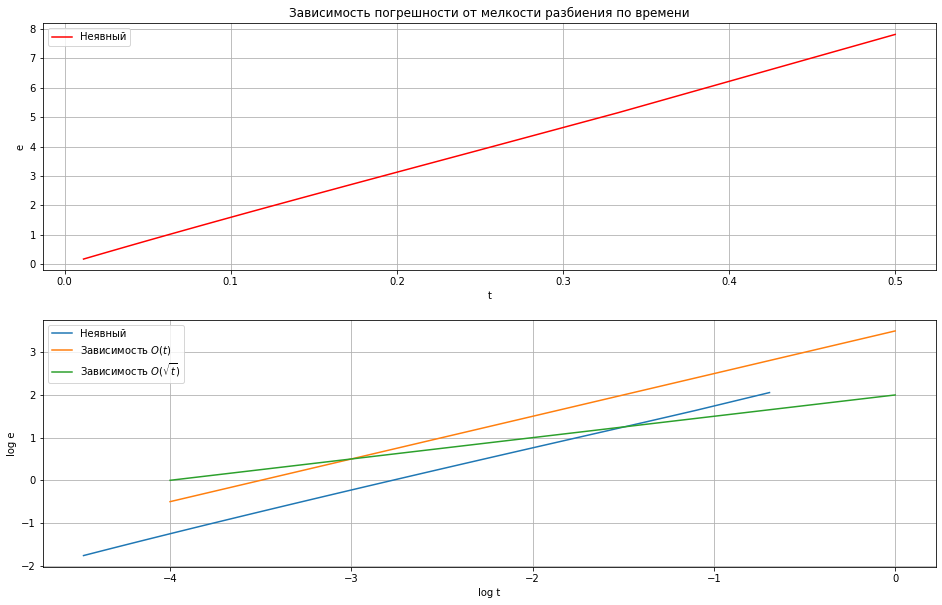

In [20]:
plt.figure(figsize = (16, 10))

plt.subplot(2, 1, 1)
plt.title("Зависимость погрешности от мелкости разбиения по времени")
tau, e = get_graphic_tau(implict, u)

plt.plot(tau, e, label="Неявный", color = "red")
plt.xlabel("t")
plt.ylabel("e")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(list(map(math.log, tau)), list(map(math.log, e)), label="Неявный")
plt.plot([-4, 0], [-0.5, 3.5], label="Зависимость $O(t)$")
plt.plot([-4, 0], [0, 2], label="Зависимость $O(\sqrt{t})$")
plt.xlabel("log t")
plt.ylabel("log e")

plt.legend()
plt.grid()

#### Сетка для реальной функции

In [21]:
def real_z(l0, l1, T, f):
    x = np.arange(l0, l1 + 0.002, 0.002)
    y = np.arange(0, T + 0.002, 0.002)
    X = np.ones((y.shape[0], x.shape[0]))
    Y = np.ones((x.shape[0], y.shape[0]))
    Z = np.ones((y.shape[0], x.shape[0]))
    for i in range(Y.shape[0]):
        Y[i] = y
    Y = Y.T
    for i in range(X.shape[0]):
        X[i] = x
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[i, j] = f(X[i, j], Y[i, j])
    return X, Y, Z

#### Явная схема

In [22]:
def plot_1(n = 5, k=10, t=1, plot = False):
    schema = Explict_Schema(T = t, aprx_cls=approx_three_two)
    x, y, z = schema(N = n, K = k)
    fig = plt.figure(num=1, figsize=(19, 12), clear=True)
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    if plot:
        ax.plot_wireframe(*real_z(0, 1, t, u), color="green")
    ax.plot_surface(np.array(x), np.array(y), np.array(z))
    ax.set(xlabel='x', ylabel='t', zlabel='z', title='График приближения и реальной функции явным методом')
    fig.tight_layout()

interact(plot_1, n=(4, 200, 2), k=(5, 200, 3), t = (1, 10, 1), plot_true = [False, True])
None

interactive(children=(IntSlider(value=5, description='n', max=200, min=4, step=2), IntSlider(value=10, descrip…

#### Неявная схема

In [23]:
def plot_2(n = 5, k=10, t=1, plot = False):
    schema = Implict_Schema(T = t, aprx_cls=approx_two_two)
    x, y, z = schema(N = n, K = k)
    fig = plt.figure(num=1, figsize=(19, 12), clear=True)
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    if plot:
        ax.plot_wireframe(*real_z(0, 1, t, u), color="green")
    ax.plot_surface(np.array(x), np.array(y), np.array(z))
    ax.set(xlabel='x', ylabel='t', zlabel='z', title='График приближения и реальной функции неявным методом')
    fig.tight_layout()

interact(plot_2, n=(4, 200, 2), k=(5, 200, 3), t = (1, 10, 1), plot_true = [False, True])
None

interactive(children=(IntSlider(value=5, description='n', max=200, min=4, step=2), IntSlider(value=10, descrip…